<a href="https://colab.research.google.com/github/chidinma-godwin/course-recommendation-nlp/blob/main/course_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 35.9 MB/s eta 0:00:00


In [1]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Suppress the TqdmExperimentalWarning
from tqdm import TqdmExperimentalWarning
import warnings
warnings.filterwarnings('ignore', category=TqdmExperimentalWarning)

In [ ]:
import re
import string
import random
import json
import os
import pickle
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import spacy

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Input, Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model

from sentence_transformers import SentenceTransformer
from datasets import load_dataset

In [ ]:
session_time = int(time.time())

In [ ]:
!nvidia-smi

Wed Jul 10 19:28:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


## Data Exploration

In [ ]:
base_dir = "/content/drive/MyDrive/project"

df = pd.read_csv(f"{base_dir}/courseslist.csv")
df.head()

,additional_course_detail,course_avg_rating,course_certificate,course_institution,course_is_classroom,course_is_university,course_level,course_link,course_name,course_num_rating,course_provider,course_subject,course_type,description,duration,is_all_time_best,pricing,start_date,teacher
0,Welcome to the world of programming! Learn the...,4.84906,True,NaN,False,False,beginner,https://www.classcentral.com/course/intro-to-p...,Introduction to Programming,53,Udacity,Programming,microcredential,Master coding basics with this 17-week Udacity...,4 months 3 weeks,False,Paid Course,On-Demand,"Karl Krueger, Kelly Howard, Julia Van Cleve, J..."
1,",This course bridges the gap between introduct...",3.66667,True,Harvard University,False,True,intermediate,https://www.classcentral.com/course/python-har...,Using Python for Research,12,edX,Programming,course,Master coding basics with this 17-week Udacity...,4 months 3 weeks,False,Paid Course,On-Demand,Jukka-Pekka JP Onnela
2,This course takes Java beginners to the next l...,4.45000,True,University of Alberta,False,True,intermediate,https://www.classcentral.com/course/object-ori...,Object-Oriented Design,40,Coursera,Programming,course,Master coding basics with this 17-week Udacity...,4 months 3 weeks,False,Paid Course,On-Demand,Kenny Wong
3,This Specialization builds on the success of t...,4.88462,True,University of Michigan,False,True,beginner,https://www.classcentral.com/course/python-186...,Python for Everybody,416,Coursera,Python,microcredential,Master coding basics with this 17-week Udacity...,4 months 3 weeks,False,Paid Course,On-Demand,Charles Russell Severance
4,This course will introduce the core data struc...,4.89328,True,University of Michigan,False,True,beginner,https://www.classcentral.com/course/python-dat...,Python Data Structures,16426,Coursera,Python,course,Master coding basics with this 17-week Udacity...,4 months 3 weeks,False,Paid Course,On-Demand,Charles Severance


In [ ]:
df.duplicated().sum()

0

In [ ]:
df = df.replace(np.nan, None)
df.isna().sum()

additional_course_detail        0
course_avg_rating               0
course_certificate              0
course_institution          20813
course_is_classroom             0
course_is_university            0
course_level                16715
course_link                     0
course_name                     0
course_num_rating               0
course_provider                 0
course_subject                  0
course_type                     0
description                     0
duration                       65
is_all_time_best                0
pricing                         0
start_date                      0
teacher                     10840
dtype: int64

In [ ]:
df['course_subject'].value_counts().reset_index().set_index('course_subject')

,count
course_subject,
Python,1332
Microsoft Azure,1198
Google Cloud Platform (GCP),1111
Uncategorized,1008
Javascript,812
...,...
Culture,1
IT Compliance,1
LDAP,1


In [ ]:
df['course_level'].value_counts(dropna=False).reset_index().set_index('course_level')

,count
course_level,
None,16715
beginner,11844
intermediate,5625
advanced,979


In [ ]:
df['pricing'].value_counts().reset_index()

,pricing,count
0,Free Online Course,11498
1,Free Trial Available,9615
2,Paid Course,9502
3,Free Online Course (Audit),2987
4,Conference Talk,747
5,Free Certificate,525
6,$14.00,28
7,"$7,500.00",15
8,$297.00,15
9,$34.00,15


In [ ]:
df['course_is_university'].value_counts().reset_index().set_index('course_is_university')

,count
course_is_university,
False,32392
True,2771


In [ ]:
df['course_provider'].value_counts().reset_index().set_index('course_provider')

,count
course_provider,
YouTube,8452
Udemy,8248
Pluralsight,4389
Coursera,3711
LinkedIn Learning,3620
...,...
Marginal Revolution University,1
OpenLearning,1
Stepik,1


In [ ]:
df[df['course_subject'] == 'Uncategorized'].head()

,additional_course_detail,course_avg_rating,course_certificate,course_institution,course_is_classroom,course_is_university,course_level,course_link,course_name,course_num_rating,course_provider,course_subject,course_type,description,duration,is_all_time_best,pricing,start_date,teacher
478,"Introduction,Project Overview,Case Scenario,Al...",0.0,False,Stanford University,True,True,None,https://www.classcentral.com/classroom/youtube...,Picking on the Same Person - Does Algorithmic ...,0,YouTube,Uncategorized,course,Stanford University offers a brief seminar exp...,35 minutes,False,Free Online Course,On-Demand,None
479,"Introduction,Linear approach,landscape changes...",0.0,False,Stanford University,True,True,None,https://www.classcentral.com/classroom/youtube...,"AI, Archaeology, and Archives - How Data Scien...",0,YouTube,Uncategorized,course,Stanford University offers a brief seminar exp...,35 minutes,False,Free Online Course,On-Demand,None
480,"Introduction,Our Story Begins,The History of t...",0.0,False,Stanford University,True,True,None,https://www.classcentral.com/classroom/youtube...,"Voices in the Code - A Story About People, The...",0,YouTube,Uncategorized,course,Stanford University offers a brief seminar exp...,35 minutes,False,Free Online Course,On-Demand,None
497,Stanford Seminar: PyWren - Pushing Microservic...,0.0,False,Stanford University,True,True,None,https://www.classcentral.com/classroom/youtube...,Stanford Seminar - PyWren - Pushing Microservi...,0,YouTube,Uncategorized,course,Stanford University offers a brief seminar on ...,45 minutes,False,Free Online Course,On-Demand,None
498,"Stanford Seminar: Data For The People, Andreas...",0.0,False,Stanford University,True,True,None,https://www.classcentral.com/classroom/youtube...,Data for the People - Andreas Weigend of Socia...,0,YouTube,Uncategorized,course,Stanford University offers a brief seminar on ...,45 minutes,False,Free Online Course,On-Demand,None


## Data Preprocessing

In [ ]:
# Function to create a meaningful combined course details
def create_combined_details(row):
    teacher_and_duration = ""
    if row['teacher'] and row['duration']:
        teacher_and_duration = f"The course was taught by {row['teacher']} and has a duration of {row['duration']}"
    elif row['teacher']:
        teacher_and_duration = f"The course was taught by {row['teacher']}"
    elif row['duration']:
        teacher_and_duration = f"The course has a duration of {row['duration']}"

    certificate = " You can get a certificate after completing this course" if row['course_certificate'] else ""

    course_institution = f" by {row['course_institution']}" if row['course_institution'] else ""

    course_level = f" and is classified as {row['course_level']} level" if row['course_level'] else ""

    combined_details = (
        f"""{row['course_name']}: This {re.sub(r' Course', '', row['pricing'])} course was rated by \
{row['course_num_rating']} people with an average rating of {round(row['course_avg_rating'], 1)}. {teacher_and_duration}. \
This {row['course_subject']} course is offered on {row['course_provider']}{course_institution}{course_level}.{certificate}. {row['additional_course_detail']}. {row['description']}"""
    )
    return combined_details

In [ ]:
# Apply the function to each row to create the combined text
df["combined_details"] = df.apply(create_combined_details, axis=1)
df["combined_details"][0]

'Introduction to Programming: This Paid course was rated by 53 people with an average rating of 4.8. The course was taught by Karl Krueger, Kelly Howard, Julia Van Cleve, James Parkes, Richard Kalehoff, Greg C., Yodit F., Matthew R., John M., Vincenzo A. and James L. and has a duration of 4 months 3 weeks. This Programming course is offered on Udacity and is classified as beginner level. You can get a certificate after completing this course. Welcome to the world of programming! Learn the skills that all programmers use, whether they build apps, web pages, or analyze data.,,. Master coding basics with this 17-week Udacity course. Learn HTML, CSS, Python, and JavaScript, with no prior programming skills required. Ideal for beginners eyeing careers in tech.'

In [ ]:
print("Min: ", min(df["combined_details"].str.split().apply(len)))
print("Max: ", max(df["combined_details"].str.split().apply(len)))

Min:  50
Max:  5448


In [ ]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Initialize stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
nlp = spacy.load('en_core_web_sm')

def preprocess_texts(texts):
    preprocessed_texts = []

    for text in texts:
        text = text.lower()
        text = re.sub(r'(?<=\d)[.](?=\d)', '√√√DOT√√√', text)  # Temporarily replace "." between numbers
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # Remove all punctuations
        text = re.sub(r'√√√DOT√√√', '.', text)  # Restore the preserved "."
        preprocessed_texts.append(text)

    lemmatized_texts = []

    for doc in nlp.pipe(preprocessed_texts, disable=["parser", "ner", "textcat"]):
        words = [token.lemma_ for token in doc if token.text not in stop_words]
        lemmatized_texts.append(' '.join(words))

    return lemmatized_texts

df['preprocessed_details'] = preprocess_texts(df['combined_details'])
df['preprocessed_details'][0]

'introduction program pay course rate 53 people average rating 4.8 course teach karl krueger kelly howard julia van cleve james parkes richard kalehoff greg c yodit f matthew r john vincenzo james l duration 4 month 3 week programming course offer udacity classify beginner level get certificate complete course welcome world programming learn skill programmer use whether build app web page analyze data master code basic 17week udacity course learn html css python javascript prior programming skill require ideal beginner eye career tech'

In [ ]:
print("Min: ", min(df["preprocessed_details"].str.split().apply(len)))
print("Max: ", max(df["preprocessed_details"].str.split().apply(len)))

Min:  30
Max:  2841


## Data Visualization

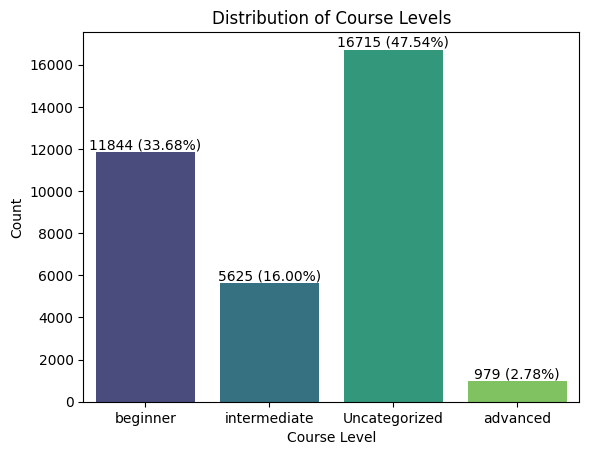

In [ ]:
filled_df = df['course_level'].fillna('Uncategorized', inplace=False)
ax = sns.countplot(x=filled_df, data=df, palette='viridis', hue=filled_df)
ax.set_title('Distribution of Course Levels')
ax.set_xlabel('Course Level')
ax.set_ylabel('Count')

# Add text on the bars
for rect in ax.patches:
    height = round(rect.get_height())
    percentage = (height / len(filled_df)) * 100
    ax.text(x=rect.get_x() + rect.get_width() / 2, y=height, s=f'{height} ({percentage:.2f}%)', ha='center', va='bottom')

plt.show()

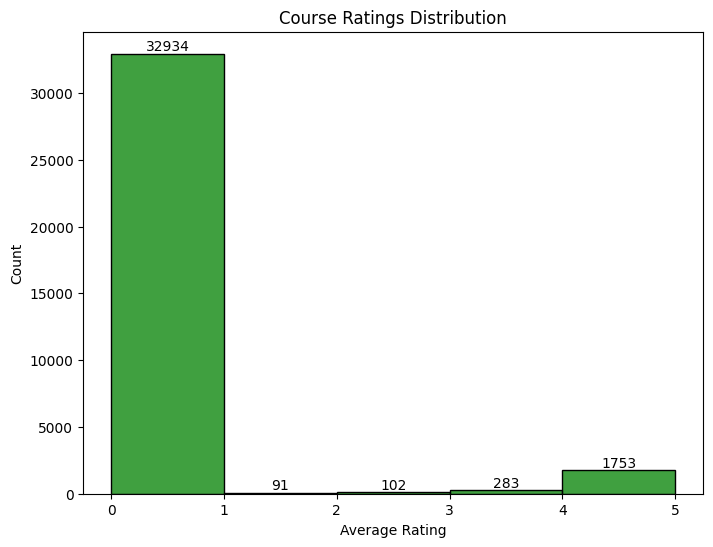

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(df['course_avg_rating'], bins=5, color='green', ax=ax)
ax.set_title('Course Ratings Distribution')
ax.set_xlabel('Average Rating')
ax.set_ylabel('Count')

# Add text on the bars
for rect in ax.patches:
    height = rect.get_height()
    ax.text(x=rect.get_x() + rect.get_width() / 2, y=height, s=height, ha='center', va='bottom')

plt.show()

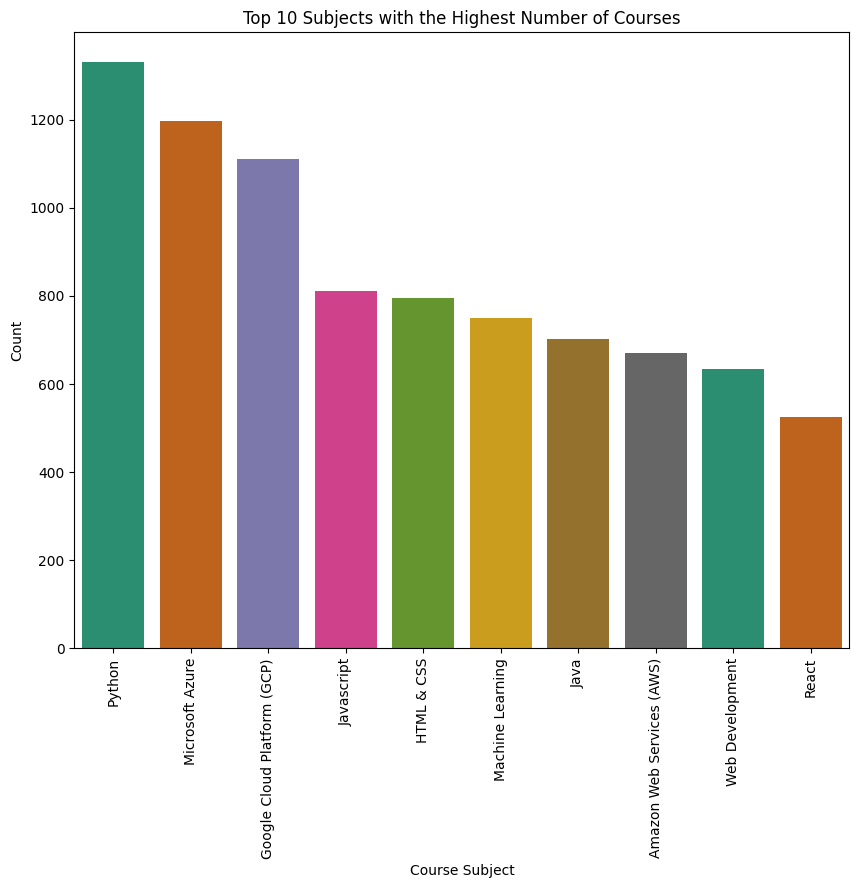

In [ ]:
top_subjects = df[df['course_subject'] != 'Uncategorized']['course_subject'].value_counts().reset_index()[:10]

fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(x='course_subject', y='count', data=top_subjects, palette='Dark2', hue='course_subject', ax=ax)
ax.set_title('Top 10 Subjects with the Highest Number of Courses')
ax.set_xlabel('Course Subject')
ax.set_ylabel('Count')

plt.xticks(rotation=90)
plt.show()

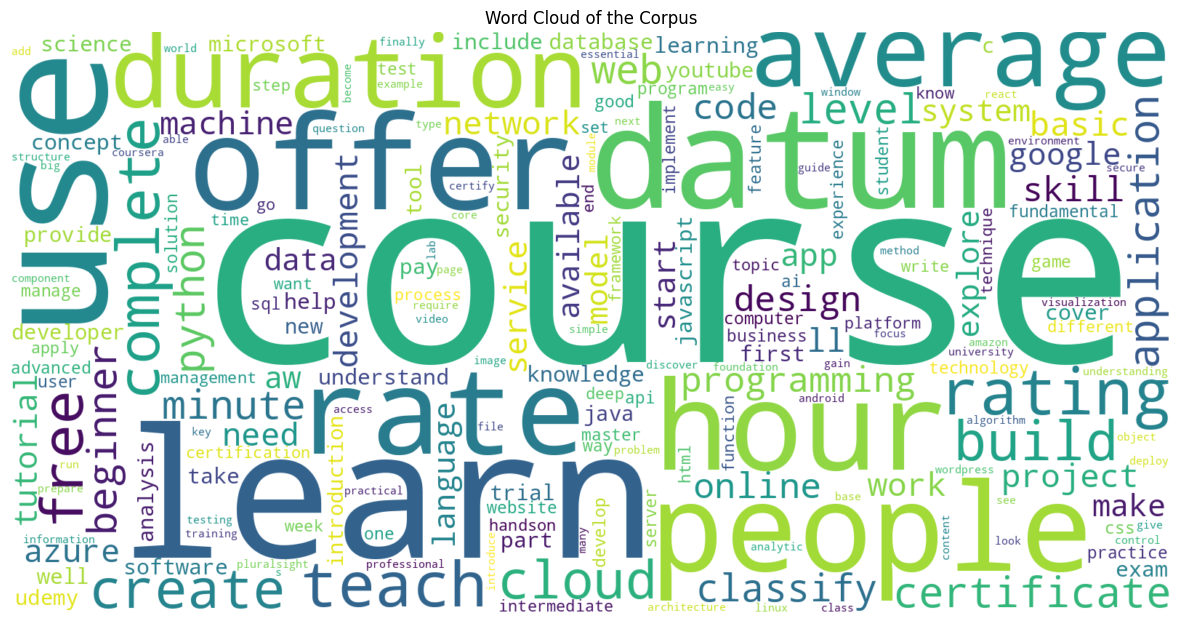

In [ ]:
wordcloud = WordCloud(width=1600, height=800, background_color='white', min_font_size=14,
                      collocations=False, max_words=200).generate(' '.join(df['preprocessed_details']))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of the Corpus')
plt.show()

## TF-IDF and Cosine Similarity

In [ ]:
def recommend_courses_cosine(user_query_embedding, course_embeddings, data, top_n=4):
    # Compute cosine similarity between user query and courses
    cosine_sim = cosine_similarity(user_query_embedding, course_embeddings).flatten()

    data['cosine_sim'] = cosine_sim
    # Get the top N similar courses
    top_indices = cosine_sim.argsort()[-top_n:][::-1]
    recommended_courses = data.iloc[top_indices]

    return recommended_courses

# Example user query
user_query = "I want advanced course on python covering OOP and data structures with an average rating above 4.0"
processed_user_query = preprocess_texts([user_query])[0]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
vectorizer = TfidfVectorizer()

# Vectorize the text data using TF-IDF
tfidf_matrix = vectorizer.fit_transform(df['preprocessed_details'])
user_tfidf = vectorizer.transform([processed_user_query])

# Get recommendations
cosine_recommendations = recommend_courses_cosine(user_tfidf, tfidf_matrix, df)
print("Cosine Similarity Recommendations:")
cosine_recommendations[['course_name', 'course_avg_rating', 'course_level', 'cosine_sim']]

Cosine Similarity Recommendations:


,course_name,course_avg_rating,course_level,cosine_sim
34964,Learn Kotlin Programming – Full Course for Beg...,0.0,None,0.492158
860,Python OOP : Four Pillars of OOP in Python 3 f...,0.0,beginner,0.477251
6556,"Data Structures and OOP with C++ : CS104, CS10...",0.0,beginner,0.452569
2130,OOP in Python 3 for Machine Learning Beginners...,0.0,beginner,0.452005


## Word2Vec and Cosine Similarity

In [ ]:
def get_average_word2vec(text, model):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

word2vec_model = Word2Vec(sentences=list(df["preprocessed_details"].str.split()), vector_size=300, window=5, min_count=1, workers=4)

course_embedding = df['preprocessed_details'].apply(lambda x: get_average_word2vec(x, word2vec_model))
user_query_embedding = get_average_word2vec(processed_user_query, word2vec_model)

cosine_recommendations = recommend_courses_cosine([user_query_embedding], course_embedding.tolist(), df)
print("Cosine Similarity Recommendations:")
cosine_recommendations[['course_name', 'course_avg_rating', 'course_level', 'cosine_sim']]

Cosine Similarity Recommendations:


,course_name,course_avg_rating,course_level,cosine_sim
25262,Python for Students,0.00000,None,0.860800
4,Python Data Structures,4.89328,beginner,0.859832
1759,Learn NumPy Fundamentals (Python Library for D...,0.00000,beginner,0.855164
21476,Lets Learn Python,0.00000,beginner,0.851917


In [ ]:
sims = word2vec_model.wv.most_similar('python', topn=10)  # get other similar words
for item in sims:
  print (item)

('panda', 0.6038721799850464)
('numpy', 0.564376175403595)
('rust', 0.5620310306549072)
('r', 0.5317306518554688)
('matplotlib', 0.5238746404647827)
('matlab', 0.5035416483879089)
('julia', 0.5000492930412292)
('seaborn', 0.4772483706474304)
('math', 0.4752694368362427)
('pandas', 0.45039811730384827)


## Doc2Vec and Cosine Similarity

In [ ]:
# Prepare data for Doc2Vec
documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(df['preprocessed_details'])]

# Train Doc2Vec model
doc2vec_model = Doc2Vec(documents, vector_size=200, window=5, min_count=1, workers=4, epochs=20)

# Sample user query
user_query_embedding = doc2vec_model.infer_vector(processed_user_query.split())

# Get course embeddings as a list of numpy arrays
course_embeddings = np.array(df['preprocessed_details'].apply(lambda x: doc2vec_model.infer_vector(x.split())).tolist())

# Recommend courses
recommended_courses = recommend_courses_cosine([user_query_embedding], course_embeddings, df)
print("Cosine Similarity Recommendations:")
recommended_courses[['course_name', 'course_avg_rating', 'course_level', 'cosine_sim']]

Cosine Similarity Recommendations:


,course_name,course_avg_rating,course_level,cosine_sim
4183,Data Structures in C++,0.0,intermediate,0.514058
23635,Learning Java using JShell,0.0,beginner,0.500613
13937,Flutter 1.2 with Firebase&Stripe Build shop ap...,0.0,intermediate,0.472535
11649,Algorithms and Data Structures - Part 2,0.0,beginner,0.449041


In [ ]:
sims = doc2vec_model.wv.most_similar('python', topn=10)  # get other similar words
for item in sims:
  print (item)

('panda', 0.5569027662277222)
('numpy', 0.4907836318016052)
('matplotlib', 0.483419269323349)
('r', 0.47346505522727966)
('java', 0.4723840355873108)
('programming', 0.45828351378440857)
('pandas', 0.4535349905490875)
('javascript', 0.4369319975376129)
('pythonpython', 0.43634602427482605)
('rust', 0.4355952739715576)


## Transformer and Cosine Similarity

In [ ]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

embedding = model.encode(df['preprocessed_details'].values)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
user_input_encoding = model.encode([processed_user_query])

# Get recommendations
cosine_recommendations = recommend_courses_cosine(user_input_encoding, embedding, df)
print("Cosine Similarity Recommendations:")
cosine_recommendations[['course_name', 'course_avg_rating', 'course_level', 'cosine_sim']]

Cosine Similarity Recommendations:


,course_name,course_avg_rating,course_level,cosine_sim
6556,"Data Structures and OOP with C++ : CS104, CS10...",0.0,beginner,0.651555
12107,Python OOP - Object Oriented Programming for B...,0.0,beginner,0.647894
4183,Data Structures in C++,0.0,intermediate,0.617137
3987,Data Analysis with Python Course,0.0,None,0.616548


## Conversational Recommendation System

In [ ]:
# Load the CLINC150 dataset using Hugging Face
dataset = load_dataset('clinc_oos', 'plus')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [ ]:
df_all = pd.concat([pd.DataFrame(dataset['train']), pd.DataFrame(dataset['validation']), pd.DataFrame(dataset['test'])])
df_selected = df_all[(df_all['intent']==42) | (df_all['intent']==82) | (df_all['intent']==114) | (df_all['intent']==124)]
oos_df = df_selected[df_selected['intent'] == 42].sample(n=300, random_state=42)
oos_df.loc[:, 'intent'] = 'oos'

df_selected = df_selected[df_selected['intent'] != 42]

df_selected.loc[df_selected['intent'] == 82, 'intent'] = 'greeting'
df_selected.loc[df_selected['intent'] == 114, 'intent'] = 'goodbye'
df_selected.loc[df_selected['intent'] == 124, 'intent'] = 'thank_you'

combined_df = pd.concat([df_selected, oos_df]).reset_index(drop=True)
combined_df['entities'] = [{} for _ in range(len(combined_df))]

combined_df

,text,intent,entities
0,"you have been a big help, thank you so much",thank_you,{}
1,"i appreciate your help, thank you",thank_you,{}
2,"i really appreciate your help, thank you",thank_you,{}
3,i am very grateful,thank_you,{}
4,i appreciate the assistance,thank_you,{}
...,...,...,...
745,can you see the second right inside the fridge,oos,{}
746,make a list of all sites in the us where spiri...,oos,{}
747,is flu contagious,oos,{}
748,is the brexit finalized yet,oos,{}


In [ ]:
# from transformers import PegasusTokenizer, PegasusForConditionalGeneration

# # Load pre-trained T5 model and tokenizer
# model_name = 'tuner007/pegasus_paraphrase'
# model = PegasusForConditionalGeneration.from_pretrained(model_name)
# tokenizer = PegasusTokenizer.from_pretrained(model_name)


# def paraphrase_intents(intents, max_length=60, num_beams=10):
#     paraphrased_intents = []
#     for intent in intents:
#         input_text = "paraphrase: " + intent
#         input_ids = tokenizer.encode(intent, return_tensors='pt', max_length=max_length, truncation=True)
#         paraphrased_ids = model.generate(input_ids, max_length=max_length, num_beams=num_beams, early_stopping=True)
#         paraphrased_text = tokenizer.decode(paraphrased_ids[0], skip_special_tokens=True)
#         paraphrased_intents.append(paraphrased_text)
#     return paraphrased_intents

In [ ]:
# Tell me some

In [ ]:
# Define intents for different entities
recommend_intents = [
    {"sent": "Can you recommend some good courses on {}?", "slots": ["topic"]},
    {"sent": "I'm looking for a course on {}. Any suggestions?", "slots": ["topic"]},
    {"sent": "What are the best courses available for {}?", "slots": ["topic"]},
    {"sent": "Could you suggest a course related to {}?", "slots": ["topic"]},
    {"sent": "I need a course on {}. What do you recommend?", "slots": ["topic"]},
    {"sent": "Please recommend a course for {}.", "slots": ["topic"]},
    {"sent": "Any recommendations for {} courses?", "slots": ["topic"]},
    {"sent": "Suggest some top courses for {}.", "slots": ["topic"]},
    {"sent": "Which courses would you recommend for learning {}?", "slots": ["topic"]},
    {"sent": "Do you have any course suggestions for {}?", "slots": ["topic"]},
    {"sent": "Can you recommend an {} course on {}?", "slots": ["level", "topic"]},
    {"sent": "I'm looking for {} courses on {}. Any suggestions?", "slots": ["level", "topic"]},
    {"sent": "What {} {} courses can you recommend?", "slots": ["level", "topic"]},
    {"sent": "Could you recommend a {} {} course?", "slots": ["certified", "topic"]},
    {"sent": "Are there any {} courses rated by {} students that you can recommend?", "slots": ["topic", "num_rating"]},
    {"sent": "Please suggest some {} courses offered by {}.", "slots": ["topic", "provider"]},
    {"sent": "Can you recommend a {} level {} course with a duration of less than {}?", "slots": ["level", "topic", "duration"]},
    {"sent": "I'm looking for a {} course that provides {}.", "slots": ["topic", "certified"]},
    {"sent": "Which {} courses would you recommend for professionals?", "slots": ["topic", "level"]},
    {"sent": "Can you recommend some short courses on {}?", "slots": ["topic"]},
    {"sent": "Any online {} courses you can suggest?", "slots": ["topic"]},
    {"sent": "Suggest some {} courses with good reviews.", "slots": ["topic"]},
    {"sent": "I'm interested in {}. Any course recommendations?", "slots": ["topic"]},
    {"sent": "What are the best-rated {} courses?", "slots": ["topic"]},
    {"sent": "Can you recommend a {} course from a top university?", "slots": ["topic"]},
    {"sent": "Looking for a part-time {} course. Any suggestions?", "slots": ["topic"]},
    {"sent": "What are the top {} courses available online?", "slots": ["topic"]},
    {"sent": "Could you recommend a {} course that offers a {}?", "slots": ["topic", "certified"]},
    {"sent": "I'm looking for a comprehensive {} course. Any suggestions?", "slots": ["topic"]},
    {"sent": "Any specialized {} courses you can recommend?", "slots": ["topic"]},
    {"sent": "What are some good self-paced {} courses?", "slots": ["topic"]},
    {"sent": "I want to learn {} Python for data science", "slots": ["level", "topic"]},
    {"sent": "Can you recommend a {} course rated {}?", "slots": ["topic", "rating"]},
    {"sent": "Is there a {} course with a {} from {}?", "slots": ["topic", "certified", "institution"]},
    {"sent": "Can you recommend a course taught by {}?", "slots": ["teacher"]},
    {"sent": "What courses on {} does {} offer?", "slots": ["topic", "provider"]},
    {"sent": "Can you suggest a {} course available at {}?", "slots": ["topic", "institution"]},
    {"sent": "I want a {} course lasting {}. Any recommendations?", "slots": ["topic", "duration"]},
    {"sent": "Can you recommend a {} course costing {}?", "slots": ["topic", "pricing"]},
    {"sent": "I would like a {} level course on {} with a rating {}", "slots": ["level", "topic", "rating"]},
    {"sent": "I would like to take an {} level course on {}.", "slots": ["level", "topic"]},
    {"sent": "I'm looking for a course on {}.", "slots": ["topic"]},
    {"sent": "I would like a {} course with a {} rating.", "slots": ["topic", "rating"]},
    {"sent": "Can you recommend a {} {} level {} course?", "slots": ["pricing", "level", "topic"]},
    {"sent": "I want a {} course that lasts {}", "slots": ["topic", "duration"]},
    {"sent": "I need a {} course with {} start date that gives {}.", "slots": ["topic", "start_date", "certified"]},
    {"sent": "Suggestions on {} {} course", "slots": ["level", "topic"]},
    {"sent": "What course covers {} and has a rating {}", "slots": ["topic", "rating"]},
    {"sent": "Which {} {} course can you recommend from a {}?", "slots": ["duration", "topic", "institution"]},
    {"sent": "Can you recommend {} courses on {}", "slots": ["duration", "topic"]},
    {"sent": "I would like a {} {} course with a rating {}", "slots": ["level", "topic", "rating"]},
    {"sent": "Does {} offer any course on {}", "slots": ["institution", "topic"]},
    {"sent": "Is there any {} course on {} offered on {}.", "slots": ["level", "topic", "provider"]},
    {"sent": "Are there any {} course that are rated by {} students with an average rating {}?", "slots": ["topic", "num_rating", "rating"]},
    {"sent": "I'm interested in a {} course", "slots": ["topic"]},
    {"sent": "What {} {} course can you recomment for a {} learner", "slots": ["duration", "topic", "level"]},
    {"sent": "What {} course with {} can you recommend for me", "slots": ["topic", "certified"]},
    {"sent": "Is there a {} course on {}", "slots": ["level", "topic"]},
    {"sent": "Can you suggest a course for {}?", "slots": ["topic"]},
    {"sent": "I'm interested in learning {}. What {} level course can you reommend", "slots": ["topic", "level"]},
]

details_intents = [
    {"sent": "Tell me more about the {} course.", "slots": ["course_name"]},
    {"sent": "I want details on the {} course.", "slots": ["course_name"]},
    {"sent": "Can you provide more information on the {} course?", "slots": ["course_name"]},
    {"sent": "Give me some details on the {} class.", "slots": ["course_name"]},
    {"sent": "I need to know more about the {} course.", "slots": ["course_name"]},
    {"sent": "What does the {} course cover?", "slots": ["course_name"]},
    {"sent": "Describe the {} course to me.", "slots": ["course_name"]},
    {"sent": "What's included in the {} course?", "slots": ["course_name"]},
    {"sent": "Could you explain the content of the {} course?", "slots": ["course_name"]},
    {"sent": "I'm interested in the {} course. Can you tell me more about it?", "slots": ["course_name"]},
    {"sent": "What is the level of the {} course?", "slots": ["course_name"]},
    {"sent": "Is the {} course {}?", "slots": ["course_name", "certified"]},
    {"sent": "How long is the {} course?", "slots": ["course_name"]},
    {"sent": "What rating does the {} course have?", "slots": ["course_name"]},
    {"sent": "Who is the provider of the {} course?", "slots": ["course_name"]},
    {"sent": "Can you give me details on the {} course?", "slots": ["course_name"]},
    {"sent": "Does the {} course offer a {}?", "slots": ["course_name", "certified"]},
    {"sent": "Is the {} course suitable for beginners?", "slots": ["course_name"]},
    {"sent": "What topics are covered in the {} course?", "slots": ["course_name"]},
    {"sent": "Who teaches the {} course?", "slots": ["course_name"]},
    {"sent": "Can you provide the syllabus for the {} course?", "slots": ["course_name"]},
    {"sent": "What are the prerequisites for the {} course?", "slots": ["course_name"]},
    {"sent": "Is the {} course self-paced?", "slots": ["course_name"]},
    {"sent": "Does the {} course have good reviews?", "slots": ["course_name"]},
    {"sent": "Is the {} course rated {}?", "slots": ["course_name", "rating"]},
    {"sent": "What is the difficulty level of the {} course?", "slots": ["course_name"]},
    {"sent": "Is there any {} upon completing the {} course?", "slots": ["certified", "course_name"]},
    {"sent": "Can you provide more info on the {} course provider?", "slots": ["course_name"]},
    {"sent": "Is the {} course self paced?", "slots": ["course_name"]},
    {"sent": "Is the {} course offered by {}?", "slots": ["course_name", "institution"]},
    {"sent": "Does the {} course start on {}?", "slots": ["course_name", "start_date"]},
    {"sent": "What is the price of the {} course?", "slots": ["course_name"]},
    {"sent": "How many ratings does the {} course have?", "slots": ["course_name"]},
    {"sent": "Is the {} course taught by {}?", "slots": ["course_name", "teacher"]},
    {"sent": "Which institution is offering the {} course?", "slots": ["course_name"]},
    {"sent": "Is the {} course {}", "slots": ["course_name", "pricing"]},
    {"sent": "Is there a {} for completing the {} course?", "slots": ["certified", "course_name"]},
    {"sent": "Which {} courses have the most ratings?", "slots": ["topic"]},
    {"sent": "I want to enroll in the {} course.", "slots": ["course_name"]},
    {"sent": "How can I sign up for the {} class?", "slots": ["course_name"]},
    {"sent": "I am interested in enrolling in the {} course.", "slots": ["course_name"]},
    {"sent": "What is the course link for the {} course?", "slots": ["course_name"]},
    {"sent": "I would like to register for the {} class.", "slots": ["course_name"]},
    {"sent": "What is the process to enroll in the {} course?", "slots": ["course_name"]},
    {"sent": "I'd like to sign up for the {} course.", "slots": ["course_name"]},
    {"sent": "I want to join the {} course.", "slots": ["course_name"]},
    {"sent": "How do I register for the {} course?", "slots": ["course_name"]},
    {"sent": "I need help enrolling in the {} course.", "slots": ["course_name"]},
    {"sent": "Can I enroll in the {} course now?", "slots": ["course_name"]},
    {"sent": "How can I join the {} course?", "slots": ["course_name"]},
    {"sent": "What steps do I need to take to enroll in the {} course?", "slots": ["course_name"]},
    {"sent": "Is enrollment open for the {} course?", "slots": ["course_name"]},
    {"sent": "I want to start the {} course. How can I enroll?", "slots": ["course_name"]},
    {"sent": "What are the enrollment dates for the {} course?", "slots": ["course_name"]},
    {"sent": "Where can I sign up for the {} course?", "slots": ["course_name"]},
    {"sent": "Is there an enrollment fee for the {} course?", "slots": ["course_name"]},
    {"sent": "What is the deadline to enroll in the {} course?", "slots": ["course_name"]},
    {"sent": "I need information on how to register for the {} course.", "slots": ["course_name"]},
    {"sent": "Is the {} course enrollment open?", "slots": ["course_name"]},
    {"sent": "Please provide the enrollment link for the {} course.", "slots": ["course_name"]}
]

topics = df['course_subject'].values

# Define entities for generation
entities = ["rating", "topic", "certified", "institution", "level", "link", "course_name",
    "num_rating", "provider", "duration", "pricing", "start_date", "teacher"]

# Define example values for each entity
entity_values = {
    "rating": ["high", "low", "4.5", "5.0", "greater than 4.0", "lesser than 3.8", "above 3.5"],
    "topic": df.loc[df["course_subject"] != "Uncategorized", "course_subject"].values,
    "certified": ["certificate", "certification"],
    "institution": [*df.loc[df['course_institution'].notna(), 'course_institution'].values, "top university"],
    "level": ["beginner", "intermediate", "advanced"],
    "link": df['course_link'].values,
    "course_name": df['course_name'].values,
    "num_rating": ["1000", "2000", "more than 1500", "less than 500"],
    "provider": df.loc[df['course_provider'].notna(), 'course_provider'].values,
    "duration": ["4 weeks", "6 months 3 weeks", "2 months", "more than 3 months", "less than 4 months", "self paced", "short"],
    "pricing": ["$50", "$100", "$200", "free"],
    "start_date": ["June 1", "July 15", "August 20", "flexible"],
    "teacher": ["John Doe", "Jane Smith", "Prof. Alan Turing"]
}

def generate_samples(intents):
    samples = []
    slots = []
    for _ in range(5):
        for intent_obj in intents:
            slots_obj = {s: random.choice(entity_values[s]) for s in intent_obj['slots']}
            samples.append(intent_obj["sent"].format(*slots_obj.values()))
            slots.append(slots_obj)

    return samples, slots


# Generate samples with entities
recommend_samples, recommend_slots_obj = generate_samples(recommend_intents)
details_samples, details_slots_obj = generate_samples(details_intents)

# Create a DataFrame for generated data
data = {
    'text': [sample for sample in recommend_samples + details_samples],
    'intent': ['recommend'] * len(recommend_samples) + ['details'] * len(details_samples),
    'entities': [entity for entity in recommend_slots_obj + details_slots_obj],
}

intent_df = pd.DataFrame(data)
all_intents_df = pd.concat([intent_df, combined_df]).reset_index(drop=True)

# Convert entity annotations to sequences of tags
def annotate_ner(text, entities):
    # words = text.split()
    words = nltk.word_tokenize(text)
    slots = ['O'] * len(words)

    for entity, value in entities.items():
        value_words = nltk.word_tokenize(value)
        for i, word in enumerate(words):
            if word in value_words:
                start_idx = words.index(value_words[0])
                slots[start_idx] = f'B-{entity}'
                for j in range(1, len(value_words)):
                    slots[start_idx + j] = f'I-{entity}'
    return slots

ner_tags = [annotate_ner(text, entities) for text, entities in zip(all_intents_df['text'], all_intents_df['entities'])]

all_intents_df['ner_tags'] = ner_tags

final_df = shuffle(all_intents_df, random_state=73).reset_index(drop=True)

final_df.head()

,text,intent,entities,ner_tags
0,search the web for monthly parking near my house,oos,{},"[O, O, O, O, O, O, O, O, O]"
1,Can you suggest a course for Hibernate?,recommend,{'topic': 'Hibernate'},"[O, O, O, O, O, O, B-topic, O]"
2,can you tell me until what time the stock mark...,oos,{},"[O, O, O, O, O, O, O, O, O, O, O, O]"
3,what channel is cw on,oos,{},"[O, O, O, O, O]"
4,I am interested in enrolling in the Serverless...,details,{'course_name': 'Serverless Data Processing wi...,"[O, O, O, O, O, O, O, B-course_name, I-course_..."


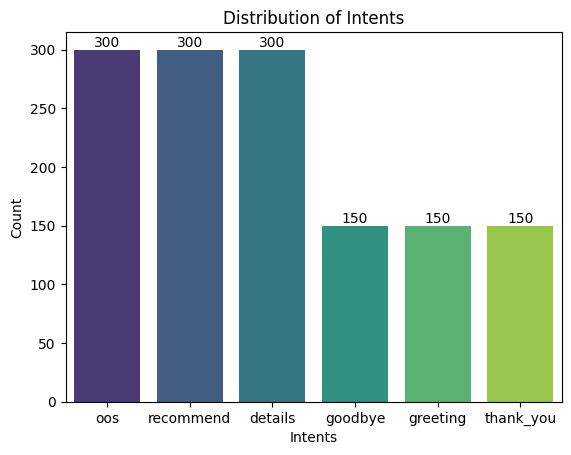

In [ ]:
ax = sns.countplot(x='intent', data=final_df, palette='viridis', hue='intent')
ax.set_title('Distribution of Intents')
ax.set_xlabel('Intents')
ax.set_ylabel('Count')

# Add text on the bars
for rect in ax.patches:
    height = round(rect.get_height())
    ax.text(x=rect.get_x() + rect.get_width() / 2, y=height, s=height, ha='center', va='bottom')

plt.show()

## Joint Intent Classifier and Slot filling Model

In [ ]:
tf.keras.utils.set_random_seed(77)

embedding_dim = 50
lstm_units = 64

intent_label_encoder = LabelEncoder()
y_intent = intent_label_encoder.fit_transform(final_df['intent'])

all_slots = ["O", "B-rating", "I-rating", "B-topic", "I-topic", "B-certified", "I-certified", "B-institution", "I-institution", "B-level", "I-level" "B-link", "I-link", "B-course_name", "I-course_name",
    "B-num_rating", "I-num_rating", "B-provider", "I-provider", "B-duration", "I-duration", "B-pricing", "I-pricing", "B-start_date", "I-start_date", "B-teacher", "I-teacher"]
slot_label_encoder = LabelEncoder()
slot_label_encoder.fit(all_slots)

max_seq_length = len(all_slots)

# Text vectorization
vectorize_layer = TextVectorization(standardize='lower', output_sequence_length=max_seq_length)
vectorize_layer.adapt(final_df['text'].values)

# Convert sentences and labels to numpy arrays
X = vectorize_layer(final_df['text'].values).numpy()

vocab_size = len(vectorize_layer.get_vocabulary())

y_slots = [[slot_label_encoder.transform([tag])[0] for tag in tags] for tags in final_df['ner_tags']]
y_slots = tf.keras.preprocessing.sequence.pad_sequences(y_slots, maxlen=max_seq_length, padding='post', value=slot_label_encoder.transform(['O'])[0])

# Convert slot labels to one-hot encoding if necessary
y_slots = tf.keras.utils.to_categorical(y_slots, num_classes=len(all_slots))

# Convert intent labels to one-hot encoding if necessary
y_intent = tf.keras.utils.to_categorical(y_intent, num_classes=len(intent_label_encoder.classes_))

x_train, x_test, y_train_intent, y_test_intent, y_train_slots, y_test_slots = train_test_split(
    X, y_intent, y_slots, test_size=0.2, random_state=42)

In [ ]:
# Define callbacks for early stopping
early_stopping = EarlyStopping(
    monitor='val_slot_output_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Define callbacks for reducing learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_slot_output_accuracy',
    mode='max',
    factor=0.2,
    patience=2,
    verbose=1
)

# Define the ModelCheckpoint callback for saving the best model
ck_path = os.path.join(base_dir, f"models/checkpoints/Joint_intent_slot{session_time}")
checkpoint_callback = ModelCheckpoint(
  filepath= ck_path,
  save_best_only=True,
  monitor='val_slot_output_accuracy',
  verbose=1
  )

In [ ]:
input_text = Input(shape=(max_seq_length,), name='input_text')
embedding = Embedding(vocab_size, embedding_dim, input_length=max_seq_length, mask_zero=True)(input_text)

bi_lstm = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding)
dropout1 = Dropout(0.2)(bi_lstm)

lstm = LSTM(lstm_units, return_sequences=True)(dropout1)
dropout2 = Dropout(0.5)(lstm)

dense = Dense(64, activation='relu')(dropout2)

# Intent classification
intent_output = Dense(len(intent_label_encoder.classes_), activation='softmax', name='intent_output')(dense[:, -1, :])

# Slot filling
slot_output = TimeDistributed(Dense(len(all_slots), activation='softmax'), name='slot_output')(dense)

# Model compilation
model = Model(inputs=input_text, outputs=[intent_output, slot_output])
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss={'intent_output': 'categorical_crossentropy', 'slot_output': 'categorical_crossentropy'},
              metrics={'intent_output': 'accuracy', 'slot_output': 'accuracy'})

# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_text (InputLayer)     [(None, 26)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 26, 50)               115750    ['input_text[0][0]']          
                                                                                                  
 bidirectional (Bidirection  (None, 26, 128)              58880     ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 dropout (Dropout)           (None, 26, 128)              0         ['bidirectional[0][0]']   

In [ ]:
history = model.fit(x_train, {'intent_output': y_train_intent, 'slot_output': y_train_slots}, validation_split=0.2, epochs=100, batch_size=16,
                    callbacks=[reduce_lr, early_stopping, checkpoint_callback])

Epoch 1/100
52/54 [===========================>..] - ETA: 0s - loss: 2.1207 - intent_output_loss: 1.0883 - slot_output_loss: 1.0324 - intent_output_accuracy: 0.5469 - slot_output_accuracy: 0.7565
Epoch 1: val_slot_output_accuracy improved from -inf to 0.83464, saving model to /content/drive/MyDrive/project/models/checkpoints/Joint_intent_slot1720372290
54/54 [==============================] - 32s 450ms/step - loss: 2.1050 - intent_output_loss: 1.0769 - slot_output_loss: 1.0282 - intent_output_accuracy: 0.5544 - slot_output_accuracy: 0.7578 - val_loss: 1.3603 - val_intent_output_loss: 0.7293 - val_slot_output_loss: 0.6310 - val_intent_output_accuracy: 0.7500 - val_slot_output_accuracy: 0.8346 - lr: 0.0100
Epoch 2/100
52/54 [===========================>..] - ETA: 0s - loss: 1.0399 - intent_output_loss: 0.4787 - slot_output_loss: 0.5612 - intent_output_accuracy: 0.8173 - slot_output_accuracy: 0.8385
Epoch 2: val_slot_output_accuracy improved from 0.83464 to 0.86435, saving model to /conte

In [ ]:
model_path = os.path.join(base_dir, f"models/Joint_intent_slot{session_time}")
model.save(model_path)

with open(os.path.join(model_path, "history.pkl"), 'wb') as file:
    # We use pickle to convert the history object into a binary
    # format and write it to a file.
    pickle.dump(history.history, file)

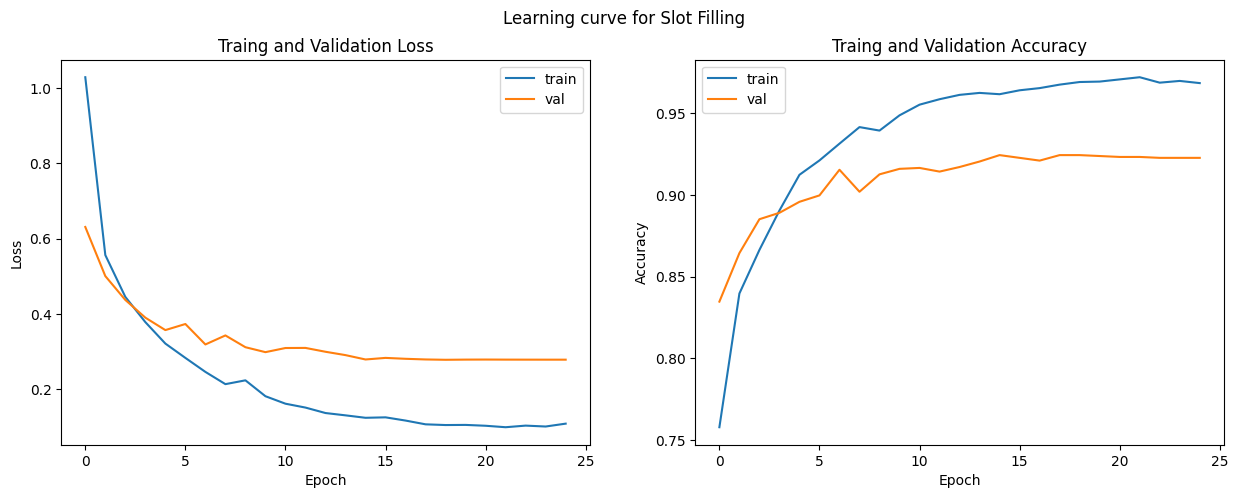

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('Learning curve for Slot Filling')

axes[0].set_title('Traing and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].plot(history.history['slot_output_loss'], label='train')
axes[0].plot(history.history['val_slot_output_loss'], label='val')
axes[0].legend()

axes[1].set_title('Traing and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].plot(history.history['slot_output_accuracy'], label='train')
axes[1].plot(history.history['val_slot_output_accuracy'], label='val')
axes[1].legend()

plt.show()

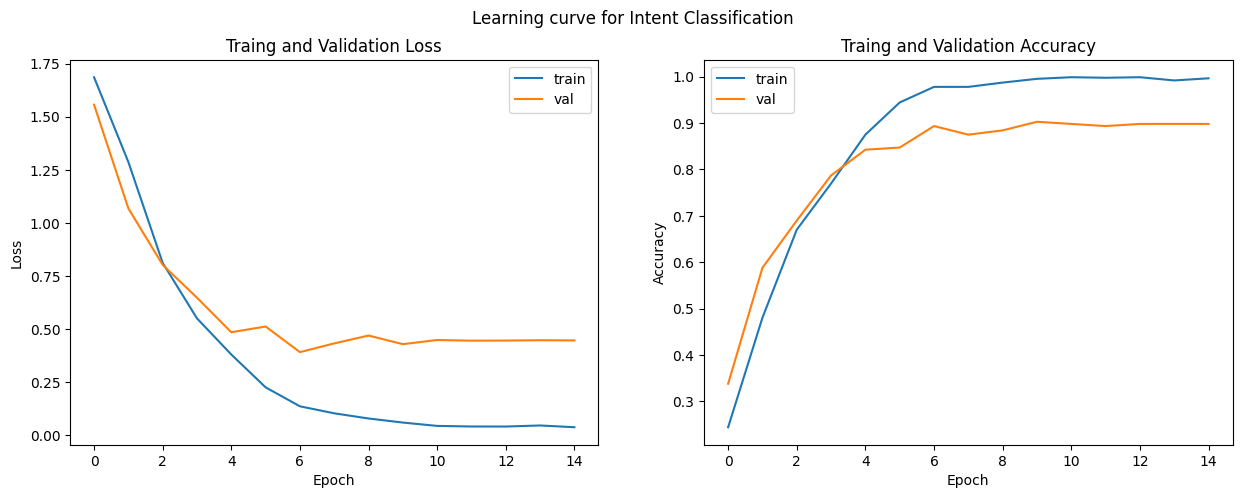

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('Learning curve for Intent Classification')

axes[0].set_title('Traing and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].plot(history.history['intent_output_loss'], label='train')
axes[0].plot(history.history['val_intent_output_loss'], label='val')
axes[0].legend()

axes[1].set_title('Traing and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].plot(history.history['intent_output_accuracy'], label='train')
axes[1].plot(history.history['val_intent_output_accuracy'], label='val')
axes[1].legend()

plt.show()

In [ ]:
model.evaluate(x_test, {'intent_output': y_test_intent, 'slot_output': y_test_slots}, batch_size=32)

9/9 [==============================] - 0s 12ms/step - loss: 0.6183 - intent_output_loss: 0.3957 - slot_output_loss: 0.2227 - intent_output_accuracy: 0.9370 - slot_output_accuracy: 0.9460


[0.6183268427848816,
 0.3956547677516937,
 0.22267206013202667,
 0.9370370507240295,
 0.9459937810897827]

In [ ]:
# model = tf.keras.models.load_model(f"{base_dir}/models/Joint_intent_slot1720377739")

# with open(f"{base_dir}/models/Joint_intent_slot1720377739/history.pkl", 'rb') as file:
#     history = pickle.load(file)

 ## Prediction and Course Retrieval

In [ ]:
def predict_intent_and_slots(sentence, label_encoder, slot_encoder):
    sentence_seq = vectorize_layer([sentence]).numpy()

    # Make predictions
    intent_pred, slot_pred = model.predict(sentence_seq)

    # Decode intent
    intent_idx = np.argmax(intent_pred, axis=1)
    intent_dict = {"intent": label_encoder.inverse_transform(intent_idx)[0]}

    # # Decode slot labels
    slot_idx = np.argmax(slot_pred[0], axis=1)
    slot_label = slot_encoder.inverse_transform(slot_idx)
    input_tokens = sentence.split()
    trimmed_slots = slot_label[:len(input_tokens)]
    print(trimmed_slots)
    indices = [i for i in range(len(trimmed_slots)) if trimmed_slots[i] != 'O']

    slots_dict = {}
    for i in indices:
        slot = trimmed_slots[i].split('-')[1]
        slots_dict[slot] = slots_dict[slot] + f" {sentence.split()[i]}" if slot in slots_dict else sentence.split()[i]

    return intent_dict, slots_dict

user_query = "I want advanced course on python covering OOP and data structures with an average rating above 4.0"
intent, slots = predict_intent_and_slots(user_query, intent_label_encoder, slot_label_encoder)

print(f"Intent: {intent}")
print(f"Slots: {slots}")

1/1 [==============================] - 3s 3s/step
['O' 'O' 'B-level' 'O' 'O' 'B-topic' 'I-topic' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'B-rating' 'I-rating']
Intent: {'intent': 'recommend'}
Slots: {'level': 'advanced', 'topic': 'python covering', 'rating': 'above 4.0'}


In [ ]:
# slots = {'level': 'advanced', 'topic': 'python covering OOP and data structures', 'rating': 'above 4.0'}
# user_query = "I want advanced course on python covering OOP and data structures with an average rating above 4.0"
# def recommend_courses_cosine(user_query_embedding, course_embeddings, data, top_n=4):
#     # Compute cosine similarity between user query and courses
#     cosine_sim = cosine_similarity(user_query_embedding, course_embeddings).flatten()

#     data['cosine_sim'] = cosine_sim
#     # Get the top N similar courses
#     top_indices = cosine_sim.argsort()[-top_n:][::-1]
#     recommended_courses = data.iloc[top_indices]

#     return recommended_courses

In [ ]:
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    words = word_tokenize(text)
    filtered_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(filtered_words)


def filter_by_rating(df, rating_value):
    rating_value = rating_value.lower()
    # Check if the rating_value is a simple number
    number_pattern = re.compile(r'^\d+(\.\d+)?$')
    if number_pattern.match(rating_value):
        rating_threshold = float(rating_value)
        filtered_df = df[df['course_avg_rating'] >= rating_threshold]
    else:
        # Check for comparison keywords and extract the numerical value
        match = re.search(r'(\d+(\.\d+)?)(?=\s*$)', rating_value)
        if match:
            rating_threshold = float(match.group(1))
            if 'above' in rating_value or 'greater' in rating_value or 'more' in rating_value:
                filtered_df = df[df['course_avg_rating'] > rating_threshold]
            elif 'below' in rating_value or 'less' in rating_value:
                filtered_df = df[df['course_avg_rating'] < rating_threshold]
            else:
                # Default to equality if no comparison keyword is found
                filtered_df = df[df['course_avg_rating'] >= rating_threshold]
        else:
            raise ValueError("Invalid rating value format")

    return filtered_df

In [ ]:
def get_matching_course(query_slots, course_df):
    # Mapping from slots to DataFrame columns
    slot_to_column = {
        "rating": "course_avg_rating",
        "topic": "course_subject",
        "certified": "course_certificate",
        "institution": "course_institution",
        "level": "course_level",
        "link": "course_link",
        "course_name": "course_name",
        "num_rating": "course_num_rating",
        "provider": "course_provider",
        "duration": "duration",
        "pricing": "pricing",
        "start_date": "start_date",
        "teacher": "teacher"
    }

    df_copy = df.copy()

    vectorizer = TfidfVectorizer()
    print(2, query_slots.items())

    for slot, value in query_slots.items():
        if slot in slot_to_column:
            column = slot_to_column[slot]

            match slot:
                case "certified":
                    df_copy = df_copy[df_copy[column] == True]
                case "rating" | "num_rating":
                    df_copy = filter_by_rating(df_copy, value)
                case "topic" | "institution" | "provider" | "teacher" | "level" |  "duration" | "start_date" | "pricing":
                    df_copy = df_copy[df_copy[column].notna()]
                    sentence_tokens = preprocess_text(value)
                    course_vector = vectorizer.fit_transform(df_copy[column].apply(preprocess_text))
                    query_vector = vectorizer.transform([sentence_tokens])
                    df_copy = recommend_courses_cosine(query_vector, course_vector, df_copy, top_n=10)

                    # df_sorted = df_copy.apply(lambda row: custom_key(row, value, column), axis=1).sort_values().index
                    # df_copy = df.loc[df_sorted]
                case _:
                    raise ValueError("Invalid slot type")

    details_vector = vectorizer.fit_transform(df_copy['additional_course_detail'].apply(preprocess_text))
    user_query_vector = vectorizer.transform([preprocess_text(user_query)])
    df_copy = recommend_courses_cosine(user_query_vector, details_vector, df_copy, top_n=5)

    return df_copy.reset_index(drop=True)


ordered_slots = ["certified", "teacher", "provider", "institution", "rating", "num_rating", "duration", "start_date", "pricing", "level", "topic"]
ordered_query_slots = {key: slots[key] for key in ordered_slots  if key in slots}

matching_courses = get_matching_course(ordered_query_slots, df)
matching_courses[['course_name', 'course_avg_rating', 'course_level', 'course_subject', 'cosine_sim']]

2 dict_items([('rating', 'above 4.0'), ('level', 'advanced'), ('topic', 'python covering OOP and data structures')])


,course_name,course_avg_rating,course_level,course_subject,cosine_sim
0,"Dynamic Programming, Greedy Algorithms",5.0,advanced,Algorithms and Data Structures,0.243031
1,Paradigms of Computer Programming – Fundamentals,5.0,advanced,Algorithms and Data Structures,0.222417
2,Data Analysis: Statistical Modeling and Comput...,5.0,advanced,Data Analysis,0.131066
3,Websites and Web Applications,5.0,advanced,Google Cloud Platform (GCP),0.105757
4,Natural intelligence,5.0,advanced,Artificial Intelligence,0.088372


In [ ]:
def get_matching_course(query_slots, course_df):
    # Mapping from slots to DataFrame columns
    slot_to_column = {
        "rating": "course_avg_rating",
        "topic": "course_subject",
        "certified": "course_certificate",
        "institution": "course_institution",
        "level": "course_level",
        "link": "course_link",
        "course_name": "course_name",
        "num_rating": "course_num_rating",
        "provider": "course_provider",
        "duration": "duration",
        "pricing": "pricing",
        "start_date": "start_date",
        "teacher": "teacher"
    }

    df_copy = df.copy()

    vectorizer = TfidfVectorizer()
    print(2, query_slots.items())

    for slot, value in query_slots.items():
        if slot in slot_to_column:
            column = slot_to_column[slot]

            match slot:
                case "certified":
                    df_copy = df_copy[df_copy[column] == True]
                case "rating" | "num_rating":
                    df_copy = filter_by_rating(df_copy, value)
                case "topic" | "institution" | "provider" | "teacher" | "level" |  "duration" | "start_date" | "pricing":
                    df_copy = df_copy[df_copy[column].notna()]
                    sentence_tokens = preprocess_text(value)
                    course_vector = vectorizer.fit_transform(df_copy[column].apply(preprocess_text))
                    query_vector = vectorizer.transform([sentence_tokens])
                    df_copy = recommend_courses_cosine(query_vector, course_vector, df_copy, top_n=20)

                    df_sorted = df_copy.apply(lambda row: custom_key(row, value, column), axis=1).sort_values().index
                    df_copy = df.loc[df_sorted]
                case _:
                    raise ValueError("Invalid slot type")

    details_vector = vectorizer.fit_transform(df_copy['additional_course_detail'].apply(preprocess_text))
    user_query_vector = vectorizer.transform([preprocess_text(user_query)])
    df_copy = recommend_courses_cosine(user_query_vector, details_vector, df_copy, top_n=5)

    return df_copy.reset_index(drop=True)


ordered_slots = ["certified", "teacher", "provider", "institution", "rating", "num_rating", "duration", "start_date", "pricing", "level", "topic"]
ordered_query_slots = {key: slots[key] for key in ordered_slots  if key in slots}

matching_courses = get_matching_course(ordered_query_slots, df)
matching_courses[['course_name', 'course_avg_rating', 'course_level', 'course_subject', 'cosine_sim']]

2 dict_items([('rating', 'above 4.0'), ('level', 'advanced'), ('topic', 'python covering')])


,course_name,course_avg_rating,course_level,course_subject,cosine_sim
0,"Dynamic Programming, Greedy Algorithms",5.00000,advanced,Algorithms and Data Structures,0.180286
1,Paradigms of Computer Programming – Fundamentals,5.00000,advanced,Algorithms and Data Structures,0.170383
2,AI for Healthcare,5.00000,advanced,Artificial Intelligence,0.147951
3,Advanced Operating Systems,4.83333,advanced,Operating Systems,0.124078
4,Design of Computer Programs,4.14286,advanced,Algorithms and Data Structures,0.117486


* investigate low cosine similarity
* try user queries that are not similar to the sample data
* try creating the embedding with word2vec and other embedding tools

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from pprint import pprint

tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    low_cpu_mem_usage=False,
    # torch_dtype=torch.float16,
    # revision="float16",
)

# model.to("cuda")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def prompt_formatter(query, context_df, intent) -> str:
    # context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])
    context = "- " + "\n- ".join(context_df["combined_details"].tolist()) if context_df is not None else None

    base_prompt = """You are an intelligent course recommendation assistant. Your goal is to provide users with clear, helpful, and engaging recommendations based on the retrieved courses and their intent. You should handle the following intents:
1. recommend: You should introduce the recommendations, list them, and provide a brief description for each course.
2. details: Provide specific details about the course.
3. oos: Politely inform the user that the question is outside your specialization.
4. greeting: Respond politely to greetings.
5. goodbye: Respond politely to farewells.
6. thank_you: Respond politely to thank-you messages.
Maintain a friendly and professional tone throughout your responses.
\nNow use the following intent to respond to the user query:
{intent}
\nNow use the following context items to respond to the user query:
{context}
\nRelevant recommendations: <extract relevant recommendations from the context here>
User query: {query}
Answer:"""
    base_prompt = base_prompt.format(intent=intent, context=context,query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
         "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                           tokenize=False,
                                           add_generation_prompt=True)

    return prompt


print(f"Query: {user_query}")


# Format our prompt
prompt = prompt_formatter(query=user_query, context_df=matching_courses, intent="recommend")
print(prompt)

Query: I want advanced course on python covering OOP and data structures with an average rating above 4.0
<|user|>
You are an intelligent course recommendation assistant. Your goal is to provide users with clear, helpful, and engaging recommendations based on the retrieved courses and their intent. You should handle the following intents:
1. recommend: You should introduce the recommendations, list them, and provide a brief description for each course.
2. details: Provide specific details about the course.
3. oos: Politely inform the user that the question is outside your specialization.
4. greeting: Respond politely to greetings.
5. goodbye: Respond politely to farewells.
6. thank_you: Respond politely to thank-you messages.
Maintain a friendly and professional tone throughout your responses.

Now use the following intent to respond to the user query:
recommend

Now use the following context items to respond to the user query:
- Dynamic Programming, Greedy Algorithms: This Free Online

In [ ]:
user_tag = re.escape("<|user|>")
assistant_tag = re.escape("<|assistant|>")
end_tag = re.escape("<|end|>")

def ask(query: str,
        intent: str,
        temperature: float=0.7,
        max_new_tokens:int=256,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # AUGMENTATION
    # Create the prompt and format it with context items
    prompt = prompt_formatter(query=query, context_df=matching_courses, intent=intent)

    # GENERATION
    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt")
        # input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 streamer=TextStreamer(tokenizer, skip_prompt=True),
                                 max_new_tokens=max_new_tokens)

    # Decode the tokens into text
    output_text = tokenizer.decode(outputs[0])

    ## Format the answer
    if format_answer_text:
        output_text = re.sub(f"{user_tag}.*?{end_tag}", '', output, flags=re.DOTALL)\
                        .replace("<|user|>", "").replace("<|end|>", "").replace("<|assistant|>", "").strip()

    # Only return the answer without context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [ ]:
from transformers import TextStreamer

print(f"Query: {user_query}")
ask(query=user_query, intent="recommend",temperature=0.6)

Query: I want advanced course on python covering OOP and data structures with an average rating above 4.0
I recommend the following courses based on your interest in advanced Python covering Object-Oriented Programming (OOP) and data structures with an average rating above 4.0:

1. Paradigms of Computer Programming – Fundamentals:
  - Teacher: Peter Van Roy
  - Duration: 6 weeks, 4-6 hours a week
  - Description: This course introduces major programming concepts, techniques, and paradigms in a unified framework, including functional, object-oriented, and declarative dataflow programming. It covers functional programming, its techniques, and data structures, as well as object-oriented programming and data abstraction.

2. Data Analysis: Statistical Modeling and Computation in Applications:
  - Teacher: Stefanie Jegelka, Caroline Uhler, Karene Chu
  - Duration: 35 minutes
  - Description: This course combines statistical and computational tools with domain knowledge to analyze real data 

"Based on your interest in an advanced course on Python covering Object-Oriented Programming (OOP) and data structures with an average rating above 4.0, I recommend the following courses:\n\n1. Paradigms of Computer Programming – Fundamentals:\n   - Rating: 5.0\n   - Duration: 6 weeks, 4-6 hours a week\n   - Description: This course covers functional, object-oriented, and declarative dataflow programming in a unified framework. It provides practical code fragments and a simple semantics to understand the concepts.\n\n2. Data Analysis: Statistical Modeling and Computation in Applications:\n   - Rating: 5.0\n   - Duration: 35 minutes\n   - Description: This course combines foundational and practical skills with domain knowledge to analyze real data using statistical and computational tools. It covers hypothesis testing, regression, and gradient descent methods.\n\n3. Websites and Web Applications:\n   - Rating: 5.0\n   - Duration: 1 hour 30 minutes\n   - Description: This course offers h